In [1]:
import flodym as fd

In [2]:
dimension_definitions = [
    fd.DimensionDefinition(letter="s", name="substance", dtype=str),
]

In [21]:
parameter_definitions = [
    fd.ParameterDefinition(name="fibre_shares", dim_letters=("s",)),
    fd.ParameterDefinition(name="manure", dim_letters=("s",)),
]

In [22]:
process_names = [
    "sysenv",
    "dewatering",
    "soil application",
    "storage",
]

In [23]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="soil application", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="soil application", to_process_name="sysenv", dim_letters=("s",)),
]

In [24]:
stock_definitions = [
    fd.StockDefinition(
        name="dummy",
        dim_letters=("s",),  # Only substance dimension
        subclass=fd.SimpleFlowDrivenStock,
        time_letter="s",
    ),
]

In [25]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    stocks=stock_definitions,
)

In [26]:
dimension_files = {
    "substance": "data/dimension_substance.csv",
}

In [27]:
parameter_files = {
    "fibre_shares": "data/parameter_fibre_shares.csv",
    "manure": "data/parameter_manure.csv",
}

In [31]:
class ManureMFA(fd.MFASystem):
    def compute(self):

        self.flows["sysenv => dewatering"][...] = self.parameters["manure"]
        self.flows["dewatering => soil application"][...] = (
            self.flows["sysenv => dewatering"] * self.parameters["fibre_shares"]
        )  # Fibres
        self.flows["dewatering => storage"][...] = (
            self.flows["sysenv => dewatering"] * (
                1 - self.parameters["fibre_shares"]
            )
        )  # Liquid
        self.flows["soil application => sysenv"][...] = (
            self.flows["dewatering => soil application"]
        )  # Soil application outflow
        self.flows["storage => sysenv"][...] = (
            self.flows["dewatering => storage"]
        )  # Storage outflow

In [33]:
mfa_example = ManureMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)

In [34]:
mfa_example.compute()

KeyError: 'fibre shares'

In [43]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mfa_example.check_mass_balance()

INFO:root:Checking mass balance of SimpleMFA object...
INFO:root:Success - Mass balance is consistent!


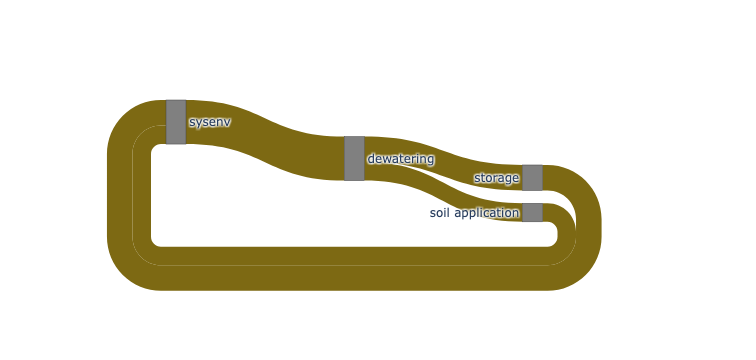

In [57]:
import flodym.export as fde

fig = fde.PlotlySankeyPlotter(mfa=mfa_example, exclude_processes=[], flow_color_dict = {"default":"rgb(125,105,19)"}).plot() 
fig.show()